In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from skimage.measure import label, regionprops
from skimage import color
from sklearn.decomposition import PCA

# Run on a single image
image_path = "test/images/01_test.tif"

# Helper functions
def threshold_level(image):
    # Convert to uint8 and flatten
    image_uint8 = (image * 255).astype(np.uint8)
    hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 256])
    hist = hist.flatten()
    bin_centers = np.arange(256)

    # Initialize
    cumulative_sum = np.cumsum(hist)

    t = np.zeros(100)  # Allocate array for thresholds

    # Initial threshold
    t[0] = np.sum(bin_centers * hist) / cumulative_sum[-1]
    t[0] = np.round(t[0])

    # Calculate mean below threshold and mean above threshold
    i = 0
    idx = int(t[i])

    if idx >= 256:
        idx = 255
    if idx <= 0:
        idx = 1

    cumulative_sum_below = np.sum(hist[:idx])
    if cumulative_sum_below > 0:
        mbt = np.sum(bin_centers[:idx] * hist[:idx]) / cumulative_sum_below
    else:
        mbt = 0

    cumulative_sum_above = np.sum(hist[idx:])
    if cumulative_sum_above > 0:
        mat = np.sum(bin_centers[idx:] * hist[idx:]) / cumulative_sum_above
    else:
        mat = 0

    # Next threshold
    i = 1
    t[i] = np.round((mat + mbt) / 2)

    # Iterate until convergence
    while abs(t[i] - t[i - 1]) >= 1 and i < 98:
        idx = int(t[i])
        if idx >= 256:
            idx = 255
        if idx <= 0:
            idx = 1

        cumulative_sum_below = np.sum(hist[:idx])
        if cumulative_sum_below > 0:
            mbt = np.sum(bin_centers[:idx] * hist[:idx]) / cumulative_sum_below
        else:
            mbt = 0

        cumulative_sum_above = np.sum(hist[idx:])
        if cumulative_sum_above > 0:
            mat = np.sum(bin_centers[idx:] * hist[idx:]) / cumulative_sum_above
        else:
            mat = 0

        i += 1
        t[i] = np.round((mat + mbt) / 2)

    threshold = t[i]
    level = threshold / 255.0

    return level

def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1):
    # Convert to float32 for numerical stability.
    diffused = img.astype(np.float32)

    for _ in range(niter):
        # Compute finite differences (gradients) in the four directions:
        # North gradient (top neighbor)
        gradN = np.roll(diffused, 1, axis=0) - diffused
        # South gradient (bottom neighbor)
        gradS = np.roll(diffused, -1, axis=0) - diffused
        # East gradient (right neighbor)
        gradE = np.roll(diffused, -1, axis=1) - diffused
        # West gradient (left neighbor)
        gradW = np.roll(diffused, 1, axis=1) - diffused

        # Perona–Malik conduction coefficients in each direction.
        # conduction function: c = exp( - (|gradI| / kappa)^2 )
        cN = np.exp(-(gradN / kappa) ** 2)
        cS = np.exp(-(gradS / kappa) ** 2)
        cE = np.exp(-(gradE / kappa) ** 2)
        cW = np.exp(-(gradW / kappa) ** 2)

        # Update the image by discrete PDE:
        diffused += gamma * (
                cN * gradN + cS * gradS +
                cE * gradE + cW * gradW
        )

    return diffused

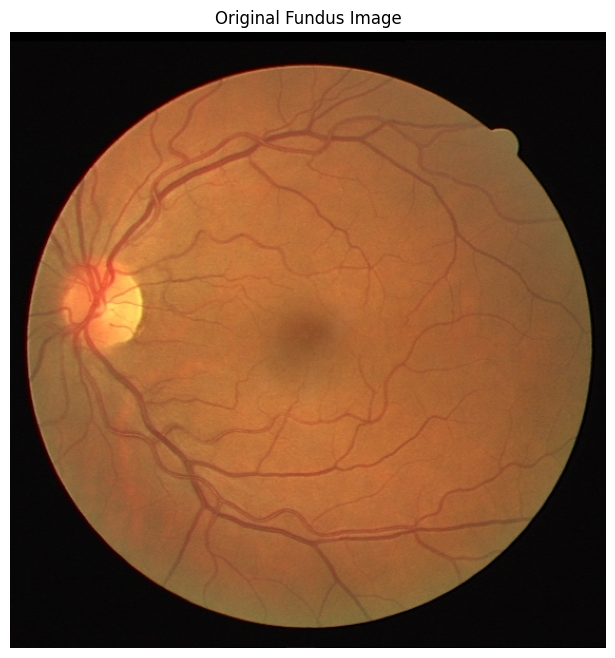

Original image dimensions: 565x584


In [55]:
# Load and display the original image
def load_and_display_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to read image: {image_path}")
        return None

    # Display the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Fundus Image")
    plt.axis('off')
    plt.show()

    return image

image = load_and_display_image(image_path)

original_height, original_width = image.shape[:2]
print(f"Original image dimensions: {original_width}x{original_height}")

Resized image dimensions: 128x128
Standard deviation of median filtered image: 0.2578


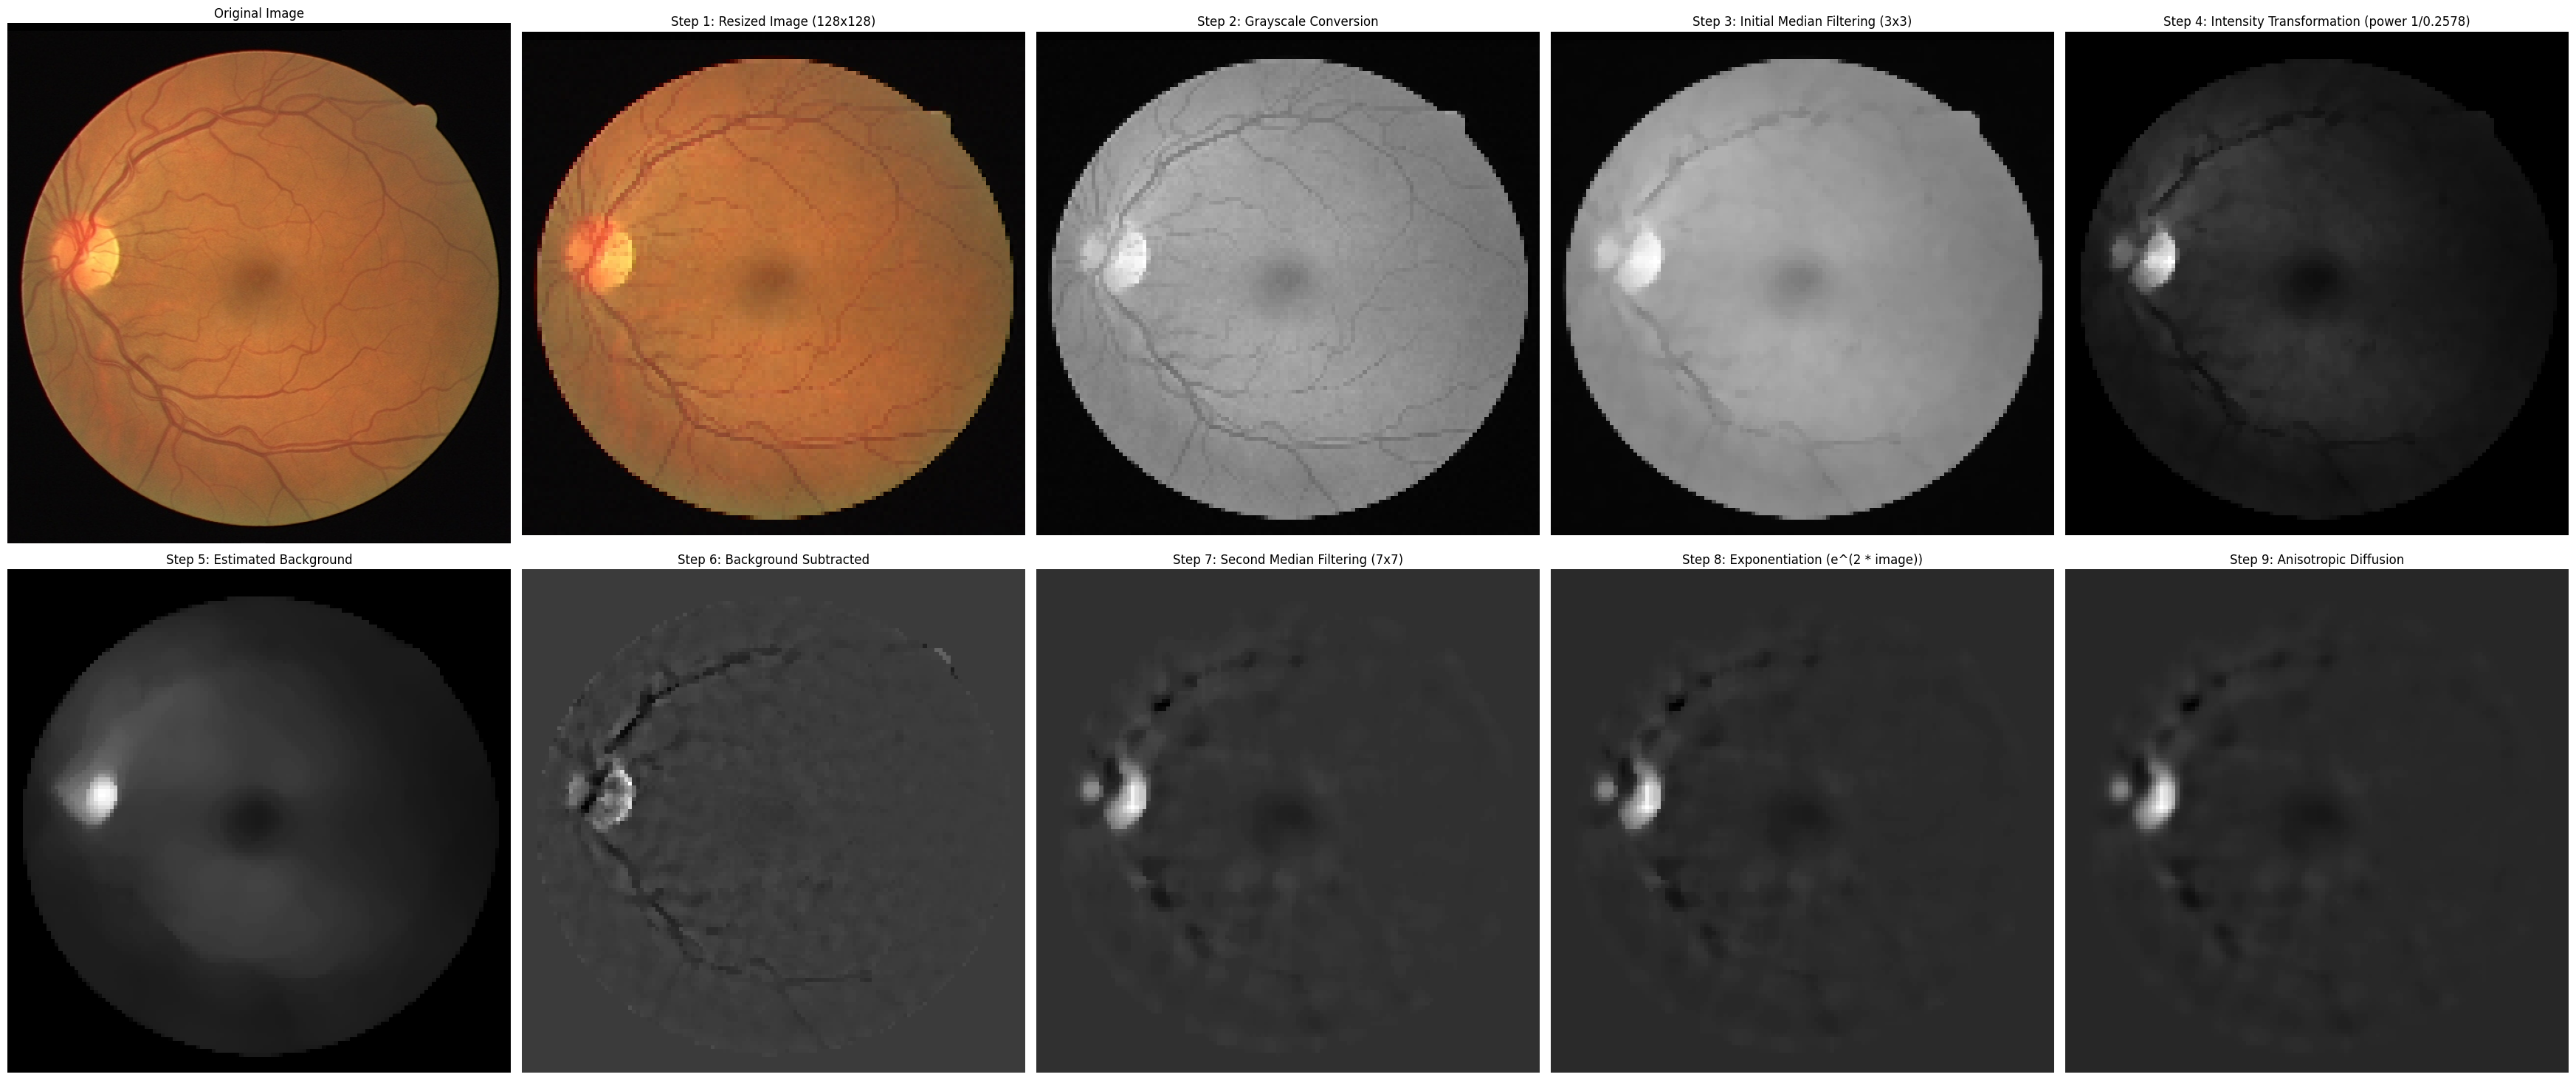

In [56]:
# Preprocess the image
def preprocess_image(image):

    # Set up the grid layout
    fig, axes = plt.subplots(2, 5, figsize=(35, 15))  # 3 rows, 4 columns
    axes = axes.flatten()  # Flatten to make indexing easier
    plot_idx = 0  # Track subplot index

    # Downscale to 128x128
    resized = cv2.resize(image, (128,128))
    resized_height, resized_width = resized.shape[:2]
    print(f"Resized image dimensions: {resized_width}x{resized_height}")

    axes[plot_idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[plot_idx].set_title("Original Image")
    axes[plot_idx].axis('off')
    plot_idx += 1

    axes[plot_idx].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    axes[plot_idx].set_title("Step 1: Resized Image (128x128)")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Convert to float in range [0,1]
    converted_image = resized.astype(np.float32) / np.max(resized)

    # Convert BGR to RGB for proper LAB conversion
    converted_image_rgb = cv2.cvtColor(converted_image, cv2.COLOR_BGR2RGB)

    # Convert to LAB color space
    lab_image = color.rgb2lab(converted_image_rgb)

    # Create a multiplier for the L channel only
    fill = np.array([1.0, 0.0, 0.0])
    filled_image = np.zeros_like(lab_image)
    filled_image[:, :, 0] = lab_image[:, :, 0] * fill[0]

    # Reshape for PCA
    h, w, c = filled_image.shape
    reshaped_lab_image = filled_image.reshape(-1, c)

    # Apply PCA
    pca = PCA(n_components=3)
    s = pca.fit_transform(reshaped_lab_image)

    # Get the first principal component and reshape
    s = s.reshape(h, w, 3)
    s = s[:, :, 0]

    # Normalize to [0,1]
    s_min = np.min(s)
    s_max = np.max(s)
    gray = (s - s_min) / (s_max - s_min)

    axes[plot_idx].imshow(gray, cmap='gray')
    axes[plot_idx].set_title("Step 2: Grayscale Conversion")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Apply median filtering with 3x3 kernel
    median_filtered = median_filter(gray, size=3)

    axes[plot_idx].imshow(median_filtered, cmap='gray')
    axes[plot_idx].set_title("Step 3: Initial Median Filtering (3x3)")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Calculate standard deviation
    sd = np.std(median_filtered)
    print(f"Standard deviation of median filtered image: {sd:.4f}")

    # Apply intensity transformation based on standard deviation
    bias = 1
    transformed = np.power(median_filtered, 1 / (bias * sd))

    axes[plot_idx].imshow(transformed, cmap='gray')
    axes[plot_idx].set_title(f"Step 4: Intensity Transformation (power 1/{bias * sd:.4f})")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Background subtraction
    # Estimate background using median filter with 9x9 kernel
    background = median_filter(transformed, size=9)

    axes[plot_idx].imshow(background, cmap='gray')
    axes[plot_idx].set_title("Step 5: Estimated Background")
    axes[plot_idx].axis('off')
    plot_idx += 1

    subtracted = transformed - background

    axes[plot_idx].imshow(subtracted, cmap='gray')
    axes[plot_idx].set_title("Step 6: Background Subtracted")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Median filter again with 7x7 kernel
    median_filtered_again = median_filter(subtracted, size=7)

    axes[plot_idx].imshow(median_filtered_again, cmap='gray')
    axes[plot_idx].set_title("Step 7: Second Median Filtering (7x7)")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Exponentiation to make bright regions brighter and dark regions darker
    a = 2
    exponentiated = np.exp(a * median_filtered_again)

    axes[plot_idx].imshow(exponentiated, cmap='gray')
    axes[plot_idx].set_title(f"Step 8: Exponentiation (e^({a} * image))")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Apply anisotropic diffusion
    niter = 2  # Too few iterations might not remove enough noise; too many can over-smooth or produce artifacts (especially if gamma is large)
    kappa = 30  # If you see too much blurring at vessel edges, lower kappa. If you see little noise reduction, increase kappa.
    gamma = 0.1  # If you see “ringing” or instability, lower gamma. If you want the same smoothing in fewer iterations, you can raise gamma
    diffused = anisotropic_diffusion(exponentiated, niter=niter, kappa=kappa, gamma=gamma)

    axes[plot_idx].imshow(diffused, cmap='gray')
    axes[plot_idx].set_title("Step 9: Anisotropic Diffusion")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Hide any unused subplots (if fewer plots than subplots)
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return diffused

# Call your function
preprocessed = preprocess_image(image)

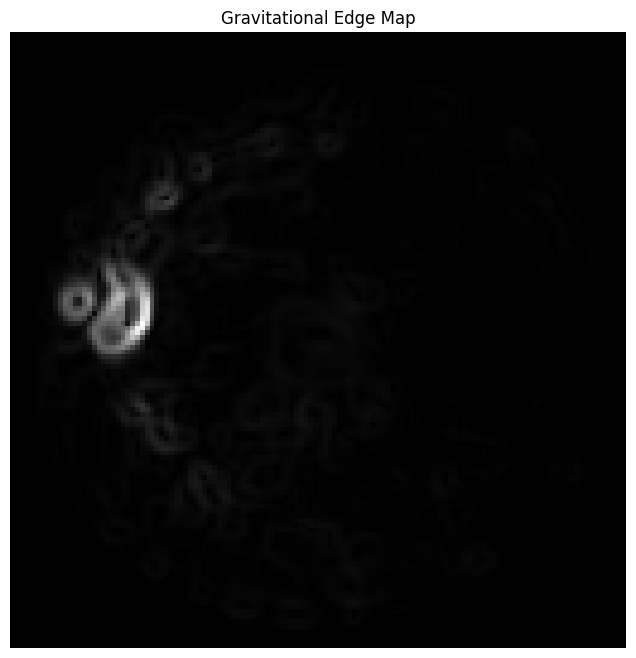

In [57]:
def gravitational_edge_detection(img):
    # Get image dimensions
    height, width = img.shape

    # Initialize the edge map
    edge_map = np.zeros((height, width), dtype=np.float64)  # To store the strength of each of the edges

    progress_counter = 0
    total_pixels = (height - 2) * (width - 2)

    # For each pixel in the image
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Progress tracking
            progress_counter += 1

            # Get the 8-neighborhood of the pixel
            neighborhood = img[i - 1:i + 2, j - 1:j + 2]

            # Calculate average intensity in the neighborhood
            g_avg = np.mean(neighborhood)

            # Calculate standard deviation in the neighborhood
            sigma = np.std(neighborhood)

            # Calculate Gravitational Constant - Strength of the Neighbours
            # If the Current pixel is very different from the mean then this makes C small -> Lowering its influence
            # If the Current pixel is similar to the mean then this makes C large -> Increasing its influence
            C = 1 / (1 + np.exp(sigma * (img[i, j] - g_avg)))

            # Initialize force components
            Fx = 0
            Fy = 0

            # For each neighbor in the 8-neighborhood
            for k in range(i - 1, i + 2):
                for l in range(j - 1, j + 2):
                    # Skip the center pixel itself
                    if k == i and l == j:
                        continue

                    # Calculate vector r from (i,j) to (k,l) -> Euclidean Distance
                    # (up,down,left,right) => r = 1
                    # Diagonals => r = sqrt(2)
                    r_magnitude = np.sqrt((k - i) ** 2 + (l - j) ** 2)

                    # Similar to newtons law -> Find the force
                    # C * img[k, l] is the mass of the neighbours and interactions coefficients
                    f_x = C * img[k, l] * (k - i) / (r_magnitude ** 3)  # (k-i)/r = unit vector in x-direction
                    f_y = C * img[k, l] * (l - j) / (r_magnitude ** 3)  # (l-j)/r = unit vector in y-direction

                    # Add to the total force components
                    Fx += f_x
                    Fy += f_y

            # Calculate the magnitude of the force
            F_magnitude = np.sqrt(Fx ** 2 + Fy ** 2)

            # Assign the magnitude to the edge map
            edge_map[i, j] = F_magnitude

    # Normalize the edge map to [0, 255]
    edge_map = (edge_map - np.min(edge_map)) / (np.max(edge_map) - np.min(edge_map)) * 255

    plt.figure(figsize=(8, 8))
    plt.imshow(edge_map, cmap='gray')
    plt.title("Gravitational Edge Map")
    plt.axis('off')
    plt.show()

    return edge_map.astype(np.uint8)

# Call your function
edge_map = gravitational_edge_detection(preprocessed)

Calculated threshold level: 0.2039


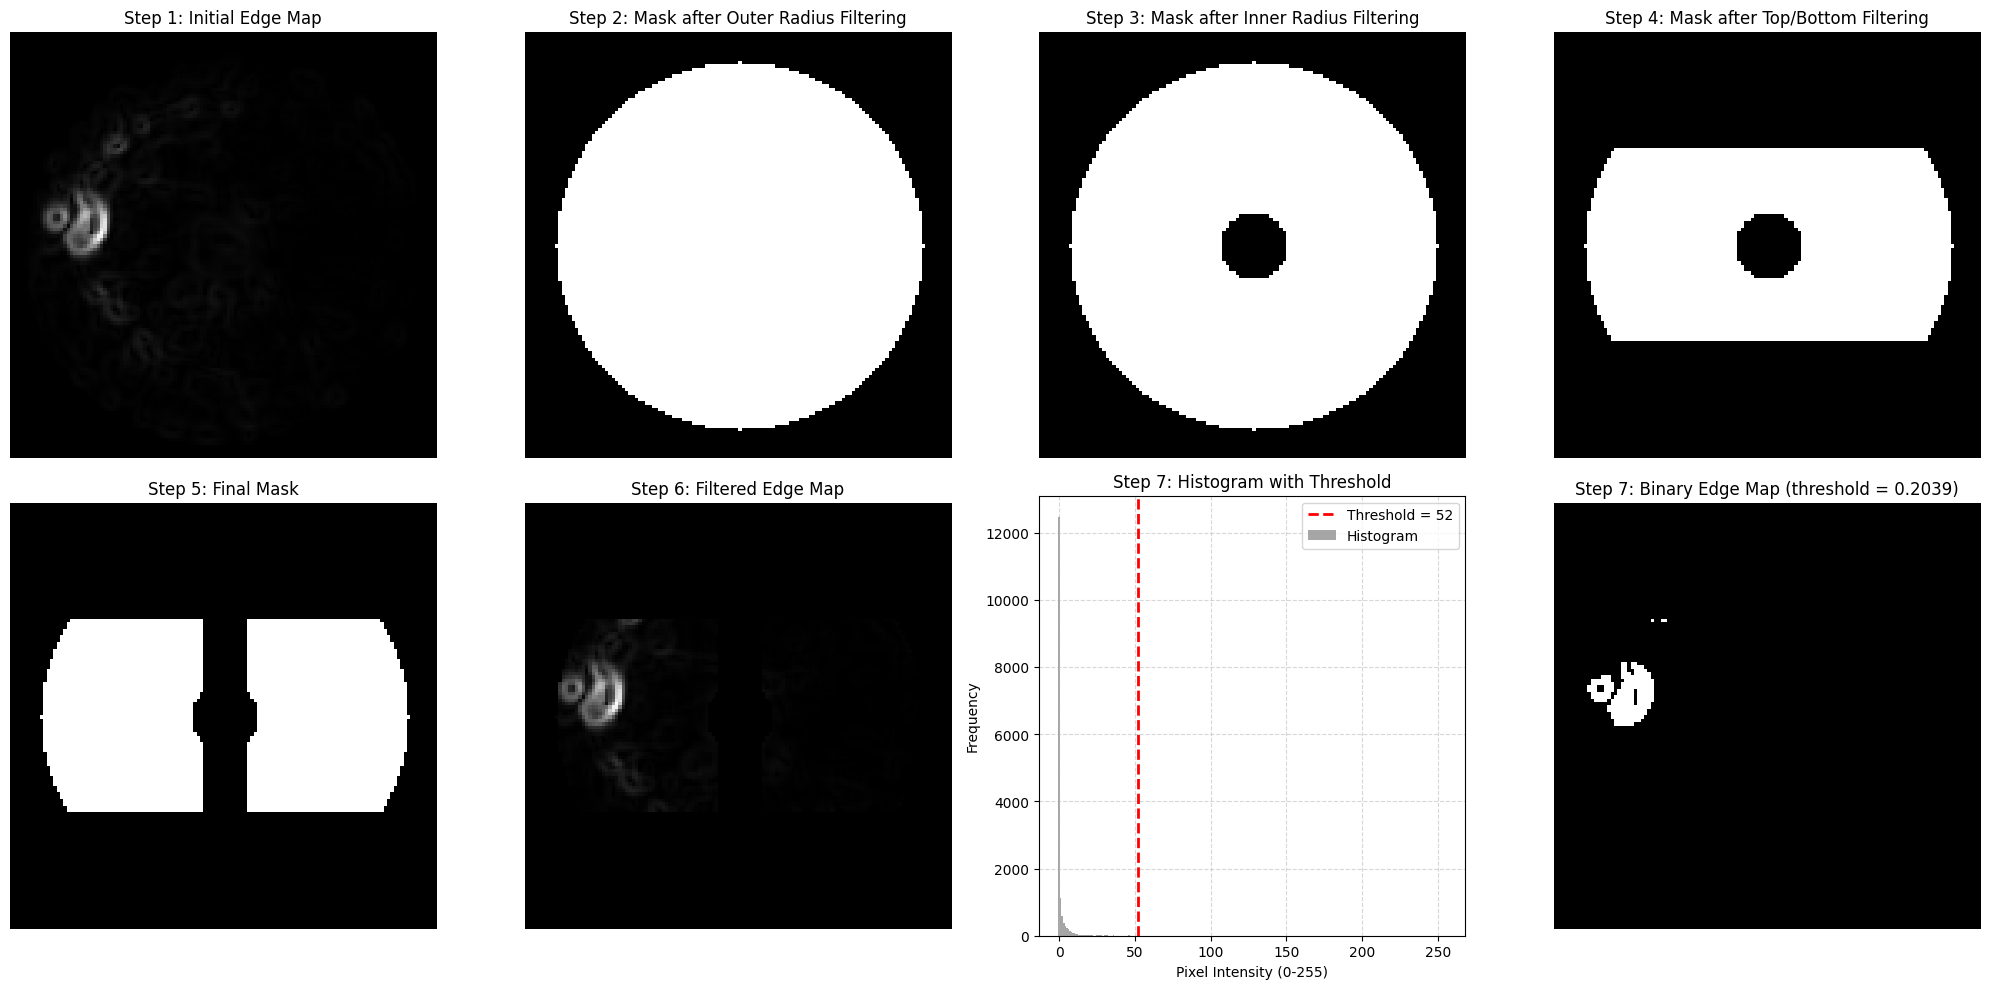

In [58]:
# Post-process edge map
def post_process_edge_map(edge_map):
    # Get image dimensions
    height, width = edge_map.shape
    center_y, center_x = height // 2, width // 2

    # Create a mask for filtering
    mask = np.ones_like(edge_map, dtype=bool)
    mask_vis = np.ones((height, width, 3), dtype=np.uint8) * 255  # Only for visualization

    # Set up subplots for visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns
    axes = axes.flatten()
    plot_idx = 0

    # Display the initial edge map
    axes[plot_idx].imshow(edge_map, cmap='gray')
    axes[plot_idx].set_title("Step 1: Initial Edge Map")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Remove pixels outside a radius of 55 pixels from the center
    for i in range(height):
        for j in range(width):
            if (i - center_y) ** 2 + (j - center_x) ** 2 > 55 ** 2:  # Equation of a Circle
                mask[i, j] = False
                mask_vis[i, j] = [0, 0, 0]  # Mark in black

    # Display the mask after outer radius filtering
    axes[plot_idx].imshow(mask_vis)
    axes[plot_idx].set_title("Step 2: Mask after Outer Radius Filtering")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Remove pixels inside a radius of 10 pixels from the center
    for i in range(height):
        for j in range(width):
            if (i - center_y) ** 2 + (j - center_x) ** 2 < 10 ** 2:
                mask[i, j] = False
                mask_vis[i, j] = [0, 0, 0]  # Mark in black

    # Display the mask after inner radius filtering
    axes[plot_idx].imshow(mask_vis)
    axes[plot_idx].set_title("Step 3: Mask after Inner Radius Filtering")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Remove rectangular regions from top and bottom (35 pixels height)
    pixel_rect = 35
    mask[:pixel_rect, :] = False
    mask[-pixel_rect:, :] = False
    mask_vis[:pixel_rect, :] = [0, 0, 0]
    mask_vis[-pixel_rect:, :] = [0, 0, 0]

    # Display the mask after top/bottom region filtering
    axes[plot_idx].imshow(mask_vis)
    axes[plot_idx].set_title("Step 4: Mask after Top/Bottom Filtering")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Remove a vertical strip of 12 pixels width from the center
    mask[:, center_x - 6:center_x + 7] = False
    mask_vis[:, center_x - 6:center_x + 7] = [0, 0, 0]

    # Display the final mask
    axes[plot_idx].imshow(mask_vis)
    axes[plot_idx].set_title("Step 5: Final Mask")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Apply the mask to the edge map
    filtered_edge_map = edge_map.copy()
    filtered_edge_map[~mask] = 0

    # Display the filtered edge map
    axes[plot_idx].imshow(filtered_edge_map, cmap='gray')
    axes[plot_idx].set_title("Step 6: Filtered Edge Map")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Thresholding
    level = threshold_level(filtered_edge_map / 255.0)
    print(f"Calculated threshold level: {level:.4f}")

    hist = cv2.calcHist([filtered_edge_map], [0], None, [256], [0, 256]).flatten()
    bin_centers = np.arange(256)
    threshold = level * 255

    axes[plot_idx].bar(bin_centers, hist, width=1.0, color='gray', alpha=0.7, label='Histogram')
    axes[plot_idx].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.0f}')
    axes[plot_idx].set_title("Step 7: Histogram with Threshold")
    axes[plot_idx].set_xlabel("Pixel Intensity (0-255)")
    axes[plot_idx].set_ylabel("Frequency")
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, linestyle='--', alpha=0.5)
    plot_idx += 1

    binary_edge_map = (filtered_edge_map > level * 255).astype(np.uint8) * 255

    # Display the binary edge map
    axes[plot_idx].imshow(binary_edge_map, cmap='gray')
    axes[plot_idx].set_title(f"Step 7: Binary Edge Map (threshold = {level:.4f})")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Hide any unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return binary_edge_map

# Call the function
binary_edge_map = post_process_edge_map(edge_map)

Number of regions found: 3
Region areas (sorted by size):
Region 1: Area = 220.0 pixels, Centroid = (np.float64(57.25), np.float64(21.14090909090909))
Region 2: Area = 2.0 pixels, Centroid = (np.float64(35.0), np.float64(32.5))
Region 3: Area = 1.0 pixels, Centroid = (np.float64(35.0), np.float64(29.0))
Region 1: Mean distance from centroid = 6.24
Suitable optic disc candidate found: Region 1
Mean distance: 6.24 < threshold (15.7)
Optic disc location (in 128x128 image): (21, 57)


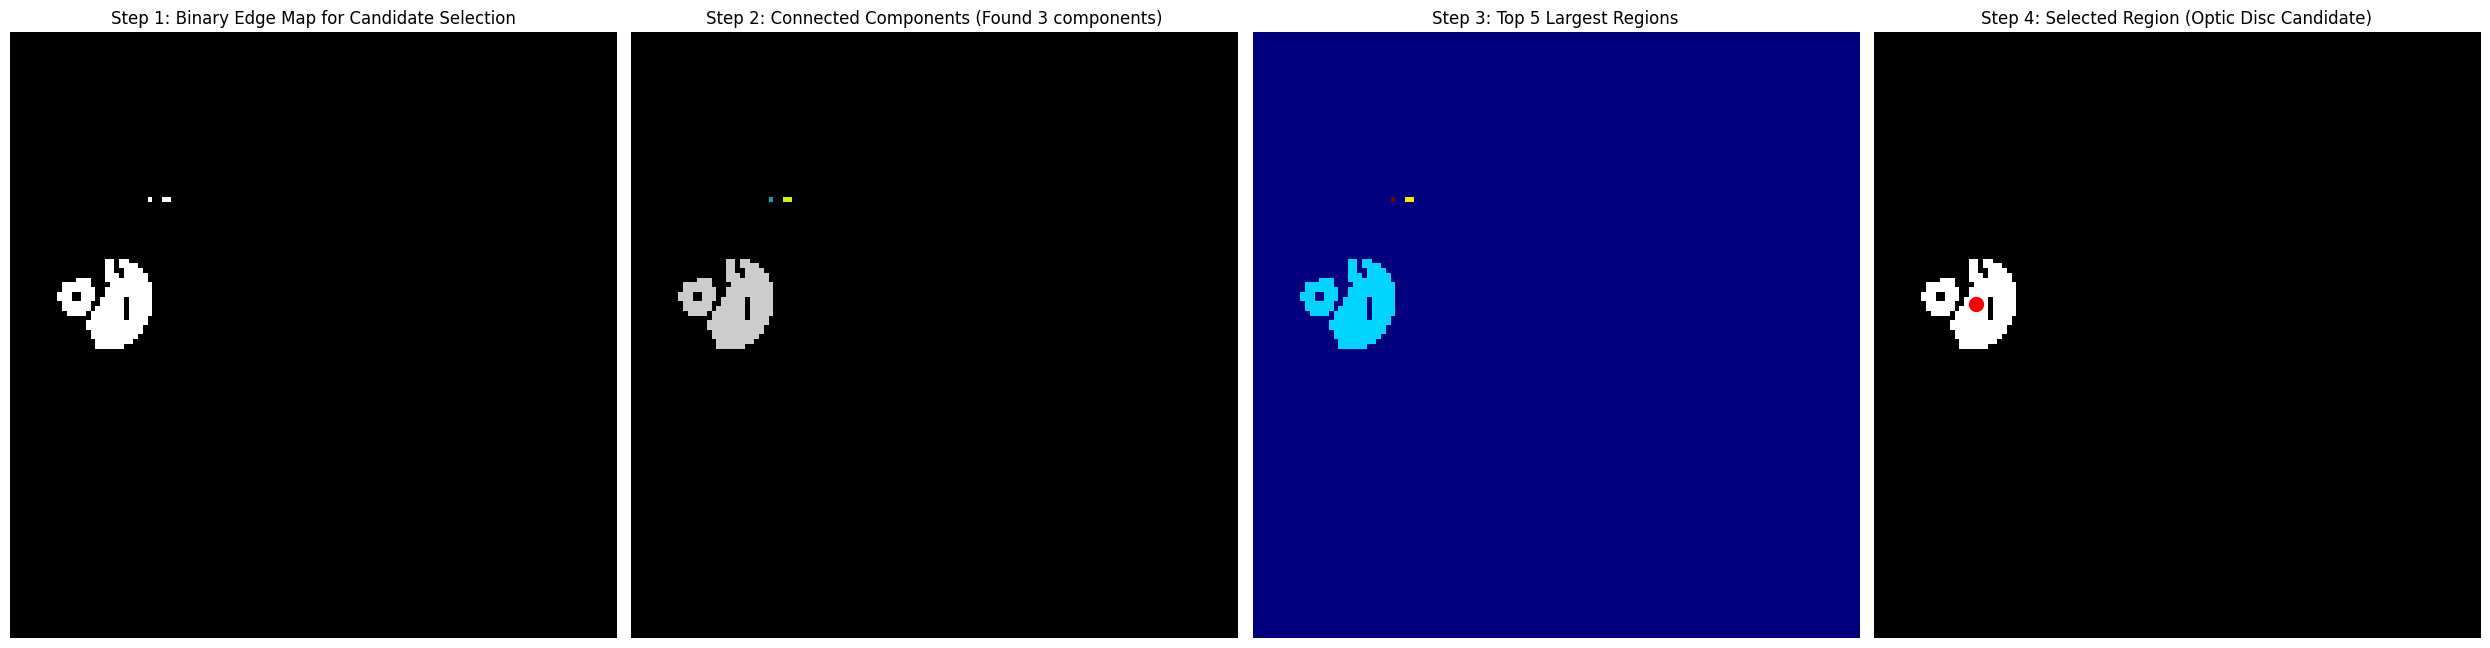

In [59]:
# Candidate selection
def candidate_selection(binary_edge_map):
    D = 15.7  # Predetermined threshold

    # Label connected components
    labeled = label(binary_edge_map)

    # Get properties of the labeled regions
    regions = regionprops(labeled)

    print(f"Number of regions found: {len(regions)}")

    # Sort regions by area (largest first)
    regions.sort(key=lambda x: x.area, reverse=True)

    if regions:
        print("Region areas (sorted by size):")
        for i, region in enumerate(regions[:5]):  # Show top 5 regions
            print(f"Region {i+1}: Area = {region.area} pixels, Centroid = {region.centroid}")

    # Create a visualization of all regions
    region_vis = np.zeros_like(binary_edge_map)

    for i, region in enumerate(regions[:5]):  # Show top 5 regions
        for coord in region.coords:
            region_vis[coord[0], coord[1]] = 50 * (i + 1)

    # Iterate through regions to find one with mean distance < D
    candidate_found = False
    selected_region_idx = -1

    for i, region in enumerate(regions):
        # Get coordinates of the pixels in the region
        coords = region.coords

        # Calculate centroid
        centroid = region.centroid

        # Calculate mean distance from centroid
        total_distance = 0
        for coord in coords:
            distance = np.sqrt((coord[0] - centroid[0]) ** 2 + (coord[1] - centroid[1]) ** 2)
            total_distance += distance

        mean_distance = total_distance / len(coords)

        print(f"Region {i+1}: Mean distance from centroid = {mean_distance:.2f}")

        # If mean distance is less than threshold, select this region
        if mean_distance < D:
            candidate_found = True
            selected_region_idx = i
            optic_disc_location = (int(centroid[1]), int(centroid[0]))
            print(f"Suitable optic disc candidate found: Region {i+1}")
            print(f"Mean distance: {mean_distance:.2f} < threshold ({D})")
            print(f"Optic disc location (in 128x128 image): {optic_disc_location}")
            break

    # If no suitable region is found, return the centroid of the largest region
    if not candidate_found and regions:
        selected_region_idx = 0
        centroid = regions[0].centroid
        optic_disc_location = (int(centroid[1]), int(centroid[0]))
        print("No region with mean distance < threshold found.")
        print(f"Using the largest region (Region 1) as the optic disc candidate.")
        print(f"Optic disc location (in 128x128 image): {optic_disc_location}")
    elif not regions:
        optic_disc_location = (64, 64)  # Center of the image
        print("No regions found at all. Using the center of the image.")
        print(f"Optic disc location (in 128x128 image): {optic_disc_location}")

    # Visualize everything side by side
    fig, axes = plt.subplots(1, 4, figsize=(25, 8))  # 2 rows x 3 columns
    axes = axes.flatten()
    plot_idx = 0

    # Display the binary edge map
    axes[plot_idx].imshow(binary_edge_map, cmap='gray')
    axes[plot_idx].set_title("Step 1: Binary Edge Map for Candidate Selection")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Create a colored visualization of the labeled components
    axes[plot_idx].imshow(labeled, cmap='nipy_spectral')
    axes[plot_idx].set_title(f"Step 2: Connected Components (Found {np.max(labeled)} components)")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Visualize the top 5 largest regions
    axes[plot_idx].imshow(region_vis, cmap='jet')
    axes[plot_idx].set_title("Step 3: Top 5 Largest Regions")
    axes[plot_idx].axis('off')
    plot_idx += 1

    # Visualize the selected region (if found)
    if selected_region_idx >= 0:
        selected_region_vis = np.zeros_like(binary_edge_map)

        for coord in regions[selected_region_idx].coords:
            selected_region_vis[coord[0], coord[1]] = 255

        axes[plot_idx].imshow(selected_region_vis, cmap='gray')
        axes[plot_idx].plot(optic_disc_location[0], optic_disc_location[1], 'ro', markersize=10)  # Mark centroid
        axes[plot_idx].set_title("Step 4: Selected Region (Optic Disc Candidate)")
        axes[plot_idx].axis('off')
        plot_idx += 1

    # Hide unused plots if less than 6
    for idx in range(plot_idx, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return optic_disc_location

# Call the function
optic_disc_location_128 = candidate_selection(binary_edge_map)


Final optic disc location (in original image): (92, 260)


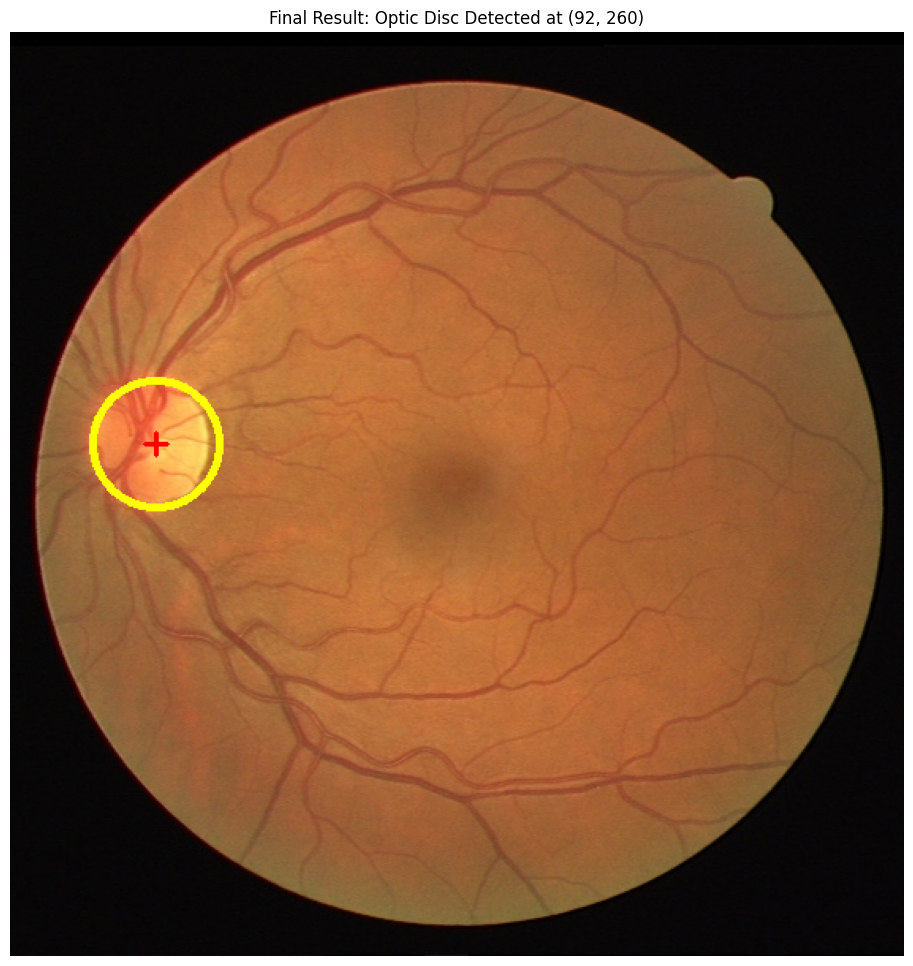

In [60]:
# Scale the location back to the original image dimensions
optic_disc_location = (
    int(optic_disc_location_128[0] * original_width / 128),
    int(optic_disc_location_128[1] * original_height / 128)
)

print(f"\nFinal optic disc location (in original image): {optic_disc_location}")

# Create final result visualization
marked_image = image.copy()

# Draw a red cross at the optic disc location
cv2.drawMarker(
    marked_image,
    optic_disc_location,
    color=(0, 0, 255),  # BGR color format
    markerType=cv2.MARKER_CROSS,
    markerSize=15,
    thickness=2
)

# Draw a circle around the optic disc location
cv2.circle(
    marked_image,
    optic_disc_location,
    radius=40,
    color=(0, 255, 255),  # BGR color format
    thickness=3
)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Final Result: Optic Disc Detected at {optic_disc_location}")
plt.axis('off')
plt.show()